In [4]:
import numpy as np
import os

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [6]:
import PIL
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
#disable_eager_execution()
enable_eager_execution()

In [322]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_datasets as tfds

In [8]:
from __future__ import print_function
import argparse
from tensorflow.keras.layers import Input
import scipy.misc

from configs import bcolors
from utils import *
import tensorflow_model_optimization as tfmot

In [9]:
def preprocess_image_resnet(features):
    """Preprocesses the given image.
       will convert the images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.
       mean = [103.939, 116.779, 123.68]
       std = None
  """
    image = features["image"]
    image = tf.image.resize(image,[224,224])
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.keras.applications.resnet.preprocess_input(image)
    features["image"] = image
    return features

In [21]:
def preprocess_image_mobilenet(features):
    """Preprocesses the given image.

      Args:
        image: `Tensor` representing an image of arbitrary size.

      Returns:
        A preprocessed image `Tensor` of range [0, 1].
  """
    image = features["image"]
    image = tf.image.resize(image,[224,224])
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    features["image"] = image
    return features

In [22]:
def preprocess_image_densenet(features):
    """Preprocesses the given image.

      Args:
        image: `Tensor` representing an image of arbitrary size.

      Returns:
        A preprocessed image `Tensor` of range [0, 1].
  """
    image = features["image"]
    image = tf.image.resize(image,[224,224])
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.keras.applications.densenet.preprocess_input(image)
    features["image"] = image
    return features

# Load Data

In [12]:
BATCH_SIZE = 50
tfds_dataset2, tfds_info  = tfds.load(name='imagenet2012_subset', split='validation[-60%:]', with_info=True,
                                     data_dir='/local/rcs/wei/image_net/') # use the last 20% of images among 50000 validation images for testing
#tf.compat.v1.data.make_one_shot_iterator(tfds_dataset1).get_next()

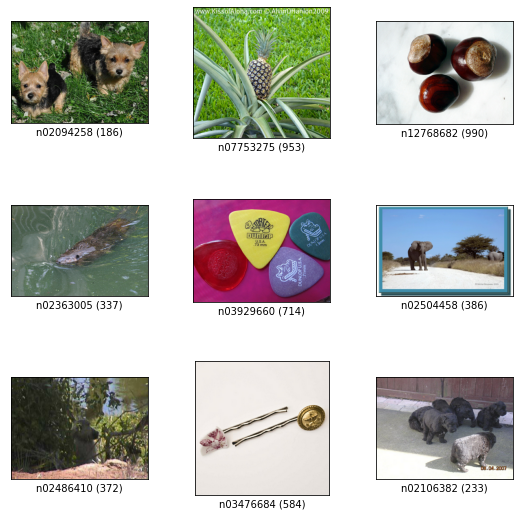

In [13]:
figs = tfds.show_examples(tfds_dataset2, tfds_info)

In [354]:
val_ds = tfds_dataset2.map(preprocess_image_mobilenet).batch(BATCH_SIZE).prefetch(1)

# Load Model

In [355]:
# input image dimensions
img_rows, img_cols = 224 ,224
input_shape = (img_rows, img_cols, 3)
model_ = tf.keras.applications.MobileNet(input_shape=input_shape)

In [356]:
q_model = tfmot.quantization.keras.quantize_model(model_)

In [357]:
model = tf.keras.applications.MobileNet(input_tensor = q_model.input)

In [358]:
model.load_weights("./fp_model_40_mobilenet.h5")
q_model.load_weights("./q_model_40_mobilenet.h5")

# Display Image

In [359]:
def extract(ith_image):
    for i, features in enumerate(val_ds):
        if ith_image < 50 and i == 0:
            image = np.expand_dims(features["image"].numpy()[ith_image], axis=0)
            label = features["label"].numpy()[ith_image]
            logits_1 = model(image)
            logits_2 = q_model(image)
            predict_1 = tf.argmax(logits_1, axis=-1).numpy()[0]
            predict_2 = tf.argmax(logits_2, axis=-1).numpy()[0]
            break
        
        elif i == np.floor(ith_image/50):
            image = np.expand_dims(features["image"].numpy()[ith_image%50], axis=0)
            label = features["label"].numpy()[ith_image%50]
            logits_1 = model(image)
            logits_2 = q_model(image)
            predict_1 = tf.argmax(logits_1, axis=-1).numpy()[0]
            predict_2 = tf.argmax(logits_2, axis=-1).numpy()[0]
            break
    return image, label,logits_1,logits_2,predict_1,predict_2

In [686]:
image,label,logits_1,logits_2,predict_1,predict_2 = extract(1)

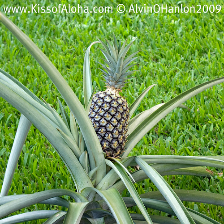

In [687]:
pil_img = tf.keras.preprocessing.image.array_to_img(image[0,:,:,:])
from IPython.display import Image
display(pil_img)

In [688]:
tf.keras.applications.resnet.decode_predictions(logits_1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.9990671),
 ('n07730033', 'cardoon', 0.00042345966),
 ('n12144580', 'corn', 0.00016192843),
 ('n13133613', 'ear', 4.107916e-05),
 ('n11939491', 'daisy', 2.415903e-05)]

In [689]:
tf.keras.applications.resnet.decode_predictions(logits_2.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.9979107),
 ('n07730033', 'cardoon', 0.0005110528),
 ('n04523525', 'vault', 0.00023726732),
 ('n04204238', 'shopping_basket', 0.00014688254),
 ('n12144580', 'corn', 0.00012124488)]

In [638]:
#np.save("./trailer_truck.npy",image)

# Baseline: PGD

$ A = argmax_A \,\, [ \,\, L( \,\, model_{quant} \,\, (image + A) , y )\,\, ]$

In [690]:
grad_iterations = 20
step = 1
epsilon = 8
input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = tf.identity(model(image))
orig_label =  np.argmax(orig_logist[0])
A = 0
loss = tf.keras.losses.SparseCategoricalCrossentropy()
for iters in range(0,grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        predict = q_model(input_image + A)
        final_loss = loss(orig_label , predict)


        grads = normalize(g.gradient(final_loss, input_image))
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image_mobilenet((input_image).numpy()) + A
    test_image_deprocess = tf.clip_by_value(test_image_deprocess, 0, 255)
    test_image = tf.keras.applications.mobilenet.preprocess_input(test_image_deprocess)
    pred1, pred2= model(test_image), q_model(test_image)
    #print(tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0])
    #print(tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0])
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Oh no!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image_mobilenet(orig_img.numpy())
            break

different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different
different


In [691]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.16826406),
 ('n04204238', 'shopping_basket', 0.07573319),
 ('n07730033', 'cardoon', 0.06858995),
 ('n03141823', 'crutch', 0.056083683),
 ('n12144580', 'corn', 0.052868046)]

In [692]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n04501370', 'turnstile', 0.13914526),
 ('n04523525', 'vault', 0.12641971),
 ('n04204238', 'shopping_basket', 0.10435372),
 ('n09332890', 'lakeside', 0.09481008),
 ('n03065424', 'coil', 0.03999199)]

# Generate adverserial example

## 1. A = argmax c*L( q_model(image + A) , sudo_y) -  L( orig_model(image + A) , y) 

In [642]:
#image = np.load("./trailer_truck.npy")

In [693]:
c = 1e2
grad_iterations = 20
step = 1
epsilon = 8

In [694]:
input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = tf.identity(model(image))
orig_label =  np.argmax(orig_logist[0])
A = 0

In [695]:
for iters in range(0,grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = tf.keras.losses.MSE(model(input_image + A)[0] , q_model(input_image + A)[0])
        # increases this loss, c should be large to make this more importatnt
        loss2 = tf.keras.losses.MSE(orig_logist[0] , model(input_image + A)[0])
        # decreases this loss
        final_loss = loss1 - c*loss2
        #print(final_loss)


        grads = normalize(g.gradient(final_loss, input_image))
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image_mobilenet((input_image).numpy()) + A
    test_image_deprocess = tf.clip_by_value(test_image_deprocess, 0, 255)
    test_image = tf.keras.applications.mobilenet.preprocess_input(test_image_deprocess)
    pred1, pred2= model(test_image), q_model(test_image)
    pred1, pred2= model(test_image), q_model(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image_mobilenet(orig_img.numpy())
            break

different
different
Success!


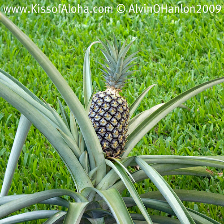

In [696]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed[0])

In [697]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.60056704),
 ('n04523525', 'vault', 0.03444618),
 ('n04204238', 'shopping_basket', 0.03256342),
 ('n03141823', 'crutch', 0.032405686),
 ('n07730033', 'cardoon', 0.029112011)]

In [698]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n04501370', 'turnstile', 0.19049785),
 ('n04523525', 'vault', 0.15724723),
 ('n07753275', 'pineapple', 0.097345464),
 ('n04204238', 'shopping_basket', 0.073005445),
 ('n09332890', 'lakeside', 0.06632875)]

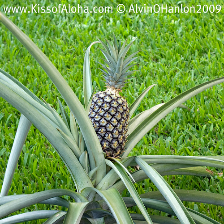

In [699]:
tf.keras.preprocessing.image.array_to_img(orig_img_deprocessed)

# Transferability

In [14]:
# input image dimensions
img_rows, img_cols = 224 ,224
input_shape = (img_rows, img_cols, 3)
#model__ = ResNet50(input_shape=input_shape)
#t_q_model = tfmot.quantization.keras.quantize_model(model__)
d_model = ResNet50(input_tensor = q_model.input)
d_model.load_weights("./distilled_fp_model_40_resnet50.h5")
#t_q_model.load_weights("./distilled_q_model_40_resnet50.h5")

In [25]:
c = 1e2
grad_iterations = 20
step = 1
epsilon = 8

In [39]:
import time
def topk(model_pred, qmodel_pred, k):
    preds = tf.keras.applications.resnet.decode_predictions(model_pred.numpy(), top=k)
    qpreds = tf.keras.applications.resnet.decode_predictions(qmodel_pred.numpy(), top=1)[0][0][1]
    
    for pred in preds[0]:
        if pred[1] == qpreds:
            return True
    
    return False

def secondk(image,k):
    image = np.expand_dims(image, axis=0)
    input_image = tf.convert_to_tensor(image)
    orig_img = tf.identity(input_image)
    
    orig_logist = tf.identity(model(image))
    orig_label =  np.argmax(orig_logist[0])
    
    quant_logist = tf.identity(q_model(image))
    quant_label =  np.argmax(quant_logist[0])

    d_logist = tf.identity(d_model(image))
    d_label =  np.argmax(d_logist[0])

    input_image = tf.convert_to_tensor(image)

    
    if orig_label != quant_label or orig_label != d_label:
        return -2,-2,-2,-2,-2
    
    A = 0
    start_time = time.time()
    for iters in range(0,grad_iterations):
        with tf.GradientTape() as g:
            g.watch(input_image)
            loss1 = K.mean(d_model(input_image+A)[..., orig_label])
            loss2 = K.mean(q_model(input_image+A)[..., orig_label])
            final_loss = K.mean(loss1 - c*loss2)


        grads = normalize(g.gradient(final_loss, input_image))
        A += tf.sign(grads) * step
        A = tf.clip_by_value(A, -epsilon, epsilon)
        test_image_deprocess = deprocess_image((input_image + A).numpy())
        test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
        pred1, pred2= d_model(test_image), q_model(test_image)
        label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
        pred3 = model(test_image)
        label3 = np.argmax(pred3[0])
        print(pred3.numpy().shape)
        
        if not topk(pred1, pred2, k):
            if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=1)[0][0][2] > 0.6:

                if label3 == orig_label and tf.keras.applications.resnet.decode_predictions(pred3.numpy(), top=1)[0][0][2] > 0.6 and not topk(pred3, pred2, k):
                    
                    total_time = time.time() - start_time
                
                    gen_img_deprocessed = test_image_deprocess
                    orig_img_deprocessed = deprocess_image(orig_img.numpy())
                    A = gen_img_deprocessed - orig_img_deprocessed
                    norm = np.max(np.abs(A))
                
                    return total_time, norm, iters, gen_img_deprocessed, A

                else:
                    return -1, -1, -1, -1, -1

            
    return -1, -1, -1, -1, -1

In [40]:
total_time, norm, iters, gen_img_deprocessed, A =  secondk(image[0],5)

(1, 1000)
(1, 1000)
(1, 1000)


KeyboardInterrupt: 

In [34]:
gen_img_deprocessed

-1

In [ ]:
test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(gen_img_deprocessed), axis=0)
pred1, pred2= model(test_image), q_model(test_image)

In [ ]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

In [ ]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

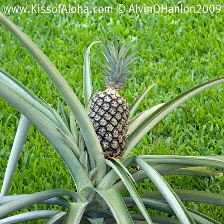

In [50]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed)

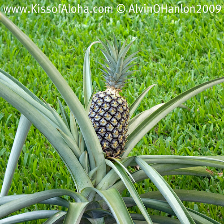

In [51]:
tf.keras.preprocessing.image.array_to_img(orig_img_deprocessed)

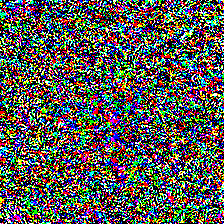

In [62]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed - orig_img_deprocessed)

## 2. A = argmax orig_model(image + A)[y] - c*q_model(image + A)[y]

In [85]:
#image = np.load("./trailer_truck.npy")

In [700]:
c = 1
grad_iterations = 20
step = 1
epsilon = 8

input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = tf.identity(model(image))
orig_label =  np.argmax(orig_logist[0])
A = 0

In [701]:
for iters in range(grad_iterations):

    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = K.mean(model(input_image+A)[..., orig_label])
        loss2 = K.mean(q_model(input_image+A)[..., orig_label])
        final_loss = K.mean(loss1 - c*loss2)

        grads = normalize(g.gradient(final_loss, input_image))

        # input_image += grads * step    
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image_mobilenet((input_image).numpy())  + A
    test_image_deprocess = tf.clip_by_value(test_image_deprocess, 0, 255)
    test_image = tf.keras.applications.mobilenet.preprocess_input(test_image_deprocess)
    pred1, pred2= model(test_image), q_model(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image_mobilenet(orig_img.numpy())
            break

different
different
Success!


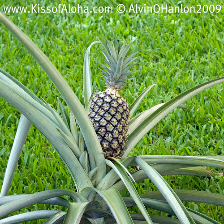

In [702]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed[0])

In [703]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.6202271),
 ('n04204238', 'shopping_basket', 0.035123162),
 ('n07730033', 'cardoon', 0.030403782),
 ('n03141823', 'crutch', 0.029964276),
 ('n04523525', 'vault', 0.027616905)]

In [704]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n04501370', 'turnstile', 0.17021246),
 ('n04523525', 'vault', 0.12765296),
 ('n07753275', 'pineapple', 0.10537171),
 ('n04204238', 'shopping_basket', 0.086979516),
 ('n09332890', 'lakeside', 0.07902484)]

# 3. Cross Entropy Loss

In [93]:
image = np.load("./trailer_truck.npy")

In [36]:
c = 1
grad_iterations = 100
transformation = 'light'
step = 1

input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_label =  np.argmax(orig_logist[0])
A = 0
epsilon = 8

In [37]:
for iters in range(grad_iterations):

    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = tf.keras.losses.categorical_crossentropy(model(input_image+A)[0] , q_model(input_image+A)[0])
        # increases this loss, c should be large to make this more importatnt
        loss2 = tf.keras.losses.categorical_crossentropy(orig_logist[0] , model(input_image+A)[0])
        # decreases this loss
        final_loss = loss1 - c*loss2
        print(final_loss)

    grads = normalize(g.gradient(final_loss, input_image))
    
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= model(test_image), q_model(test_image)
    label_ = np.argmax(pred1[0])
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        print(label1)
        print(label2)
        print(tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0])
        print(tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0])
        if label_ == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            break

tf.Tensor(0.024632435, shape=(), dtype=float32)
tf.Tensor(1.9073097, shape=(), dtype=float32)
different
703
192
[('n03891251', 'park_bench', 0.58444065), ('n04099969', 'rocking_chair', 0.07364099), ('n03065424', 'coil', 0.039980598), ('n02788148', 'bannister', 0.035499506), ('n07753275', 'pineapple', 0.029675419)]
[('n02096177', 'cairn', 0.17993566), ('n03891251', 'park_bench', 0.065755755), ('n02097298', 'Scotch_terrier', 0.052124914), ('n02097209', 'standard_schnauzer', 0.04131967), ('n04099969', 'rocking_chair', 0.03539141)]
tf.Tensor(-0.06357074, shape=(), dtype=float32)
different
953
192
[('n07753275', 'pineapple', 0.9211497), ('n03141823', 'crutch', 0.00630693), ('n03065424', 'coil', 0.0059025045), ('n04501370', 'turnstile', 0.004526963), ('n02096177', 'cairn', 0.0037871855)]
[('n02096177', 'cairn', 0.16559218), ('n02097298', 'Scotch_terrier', 0.051831927), ('n02097209', 'standard_schnauzer', 0.0325702), ('n07753275', 'pineapple', 0.0325702), ('n02113712', 'miniature_poodle', 0.0

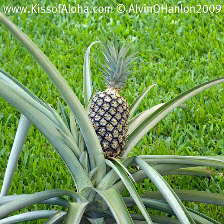

In [38]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed)

In [39]:
print(A)

tf.Tensor(
[[[[-1. -1. -1.]
   [-1. -1. -3.]
   [ 3. -1. -3.]
   ...
   [ 1.  1.  1.]
   [ 3. -1. -1.]
   [ 3.  1. -1.]]

  [[-3. -1.  1.]
   [-1. -1. -1.]
   [ 1.  1.  1.]
   ...
   [ 1.  1.  1.]
   [ 1. -1. -3.]
   [-1. -1. -1.]]

  [[-3. -3.  1.]
   [ 1. -3.  1.]
   [ 3. -3.  1.]
   ...
   [ 1.  1.  1.]
   [ 1.  1.  1.]
   [ 1. -1. -1.]]

  ...

  [[-1. -1.  1.]
   [-1. -1.  1.]
   [ 1. -3.  1.]
   ...
   [-3.  3.  3.]
   [-1.  1.  1.]
   [ 1.  1.  1.]]

  [[ 3.  1.  1.]
   [-1. -1. -1.]
   [-1. -1. -3.]
   ...
   [-1.  1.  3.]
   [-1.  1.  1.]
   [-3. -3.  1.]]

  [[-1. -1. -1.]
   [ 1.  1.  1.]
   [ 1.  1.  1.]
   ...
   [ 1.  1.  1.]
   [-3. -3.  1.]
   [-1. -3. -1.]]]], shape=(1, 224, 224, 3), dtype=float32)


In [98]:
test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(gen_img_deprocessed), axis=0)
pred1, pred2= model(test_image), q_model(test_image)
label_ = np.argmax(pred1[0])
label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])

In [99]:
label1, label2

(867, 170)